In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import urllib2
from __future__ import division

plt.style.use('ggplot')
np.random.seed(1)
url = ('https://raw.githubusercontent.com/Upward-Spiral-Science'
       '/data/master/syn-density/output.csv')
data = urllib2.urlopen(url)
data = np.genfromtxt(data, delimiter=",")[1:] # don't want first row (labels)

# convert to density
data = np.array([row for row in data if row[-2] != 0])
data[:, -2] = data[:, -1]/data[:, -2]
data = data[:,:-1]
print "density mean: ", np.average(data[:, -1])
print "density std dev: ", np.std(data[:, -1])
# normalize
means = [np.average(data[:, i]) for i in range(4)]
std_devs = [np.std(data[:, i]) for i in range(4)]
for i in range(4):
    data[:, i] -= means[i]
    data[:, i] /= std_devs[i]
print data

density mean:  0.0010395174988
density std dev:  0.000530141662849
[[-1.71622834 -1.68086449 -1.61734007 -1.96082966]
 [-1.71622834 -1.68086449 -1.30057464 -1.96082966]
 [-1.71622834 -1.68086449 -0.98380921 -1.96082966]
 ..., 
 [ 1.75530596  1.6162681   0.60001794 -1.96082966]
 [ 1.75530596  1.6162681   0.91678337 -1.96082966]
 [ 1.75530596  1.68953771  0.60001794 -1.96082966]]


Bock 2011 paper claims they cut 4 different layers, so we will do k-means w/ 4 clusters.

In [2]:
from sklearn import cluster

kmeans1 = cluster.KMeans(4)
kmeans1.fit_predict(data)

print kmeans1.cluster_centers_

[[ 0.0484905  -0.46936266 -1.01446328  0.56021856]
 [ 1.03596524  0.73796334  0.16176808 -0.71712894]
 [ 0.06112662 -0.63812922  0.79986495  0.57186693]
 [-1.0488104   0.69995538  0.14541929 -0.75067006]]


Note pairs of clusters with similar mean densities and y-values.

Since we have seen numerous times that it appears layers change along y-axis, lets cluster our data based only on density and y value and then compare these to the previous clustering.

In [3]:
data_yd = data[:, (1, 3)]

kmeans2 = cluster.KMeans(4)
kmeans2.fit_predict(data_yd)

print kmeans2.cluster_centers_

[[-0.90468587  0.78234562]
 [ 0.68800617  0.27277469]
 [ 1.18178407 -1.39504177]
 [-0.78322062 -1.16887995]]


This clustering result is more along the lines of what we expected, as it partitions by different y-values and densities. Let's make some graphs of the previous two clusters.

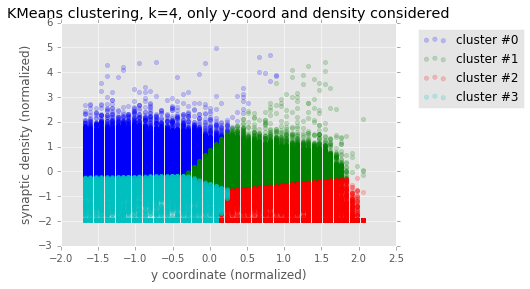

[[-0.90468587  0.78234562]
 [ 0.68800617  0.27277469]
 [ 1.18178407 -1.39504177]
 [-0.78322062 -1.16887995]]


In [4]:
colors = ['b', 'g', 'r', 'c', 'm']

for i, c in zip(range(4), colors):
    a = np.where(kmeans2.labels_ == i)
    plt.scatter(data[a, 1], data[a, -1], 
                alpha = .2,
                color = c, 
                label='cluster #' + str(i))

plt.legend(bbox_to_anchor=(1.4, 1.00))
plt.xlabel('y coordinate (normalized)')
plt.ylabel('synaptic density (normalized)')
plt.title('KMeans clustering, k=4, only y-coord and density considered')
plt.show()


print kmeans2.cluster_centers_

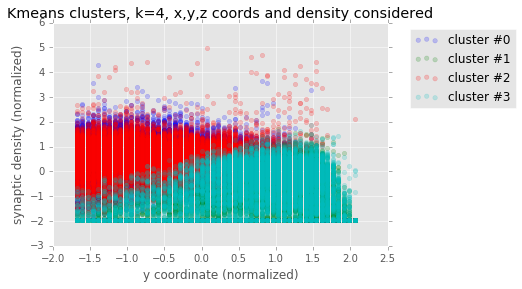

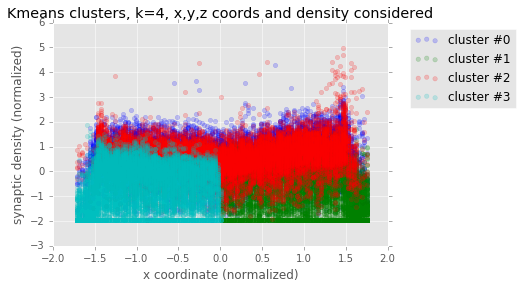

[[ 0.0484905  -0.46936266 -1.01446328  0.56021856]
 [ 1.03596524  0.73796334  0.16176808 -0.71712894]
 [ 0.06112662 -0.63812922  0.79986495  0.57186693]
 [-1.0488104   0.69995538  0.14541929 -0.75067006]]


In [13]:
for i, c in zip(range(4), colors):
    a = np.where(kmeans1.labels_ == i)
    plt.scatter(data[a, 1], data[a, -1], 
                alpha = .2,
                color = c, 
                label='cluster #' + str(i))

plt.legend(bbox_to_anchor=(1.4, 1.00))
plt.xlabel('y coordinate (normalized)')
plt.ylabel('synaptic density (normalized)')
plt.title('Kmeans clusters, k=4, x,y,z coords and density considered')
plt.show()

for i, c in zip(range(4), colors):
    a = np.where(kmeans1.labels_ == i)
    plt.scatter(data[a, 0], data[a, -1], 
                alpha = .2,
                color = c, 
                label='cluster #' + str(i))

plt.legend(bbox_to_anchor=(1.4, 1.00))
plt.xlabel('x coordinate (normalized)')
plt.ylabel('synaptic density (normalized)')
plt.title('Kmeans clusters, k=4, x,y,z coords and density considered')
plt.show()
print kmeans1.cluster_centers_

Observe the similarity in clusters when projected onto the y-axis. Also note difference in x and z coordinate means for the first 2 and second 2 clusters. Let's try kmeans with k=2.

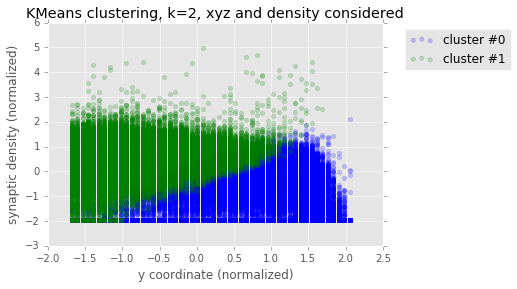

[[-0.152116    0.76489027  0.1396907  -0.64606014]
 [ 0.13323595 -0.66995505 -0.12235283  0.56587366]]


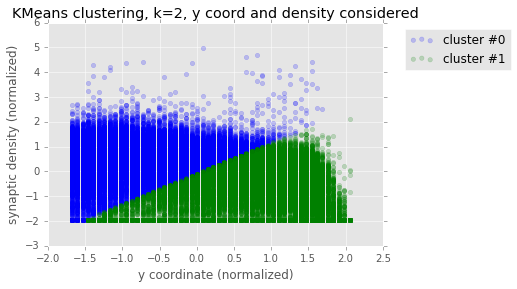

[[-0.69469144  0.56362751]
 [ 0.78241123 -0.63479764]]


In [6]:
kmeans3 = cluster.KMeans(2)
kmeans3.fit_predict(data)

for i, c in zip(range(2), colors):
    a = np.where(kmeans3.labels_ == i)
    plt.scatter(data[a, 1], data[a, -1], 
                alpha = .2,
                color = c, 
                label='cluster #' + str(i))

plt.legend(bbox_to_anchor=(1.4, 1.00))
plt.xlabel('y coordinate (normalized)')
plt.ylabel('synaptic density (normalized)')
plt.title('KMeans clustering, k=2, xyz and density considered')
plt.show()
print kmeans3.cluster_centers_

kmeans4 = cluster.KMeans(2)
kmeans4.fit_predict(data[:, (1, 3)])

for i, c in zip(range(2), colors):
    a = np.where(kmeans4.labels_ == i)
    plt.scatter(data[a, 1], data[a, -1], 
                alpha = .2,
                color = c, 
                label='cluster #' + str(i))

plt.legend(bbox_to_anchor=(1.4, 1.00))
plt.xlabel('y coordinate (normalized)')
plt.ylabel('synaptic density (normalized)')
plt.title('KMeans clustering, k=2, y coord and density considered')
plt.show()
print kmeans4.cluster_centers_

Fit 2 gaussians...

[[-0.0696716   0.48174884  0.06995895 -0.63929637]
 [ 0.06865054 -0.4746886  -0.06893367  0.62992721]]
compare with kmeans, k=2, all coordinates
[[-0.152116    0.76489027  0.1396907  -0.64606014]
 [ 0.13323595 -0.66995505 -0.12235283  0.56587366]]


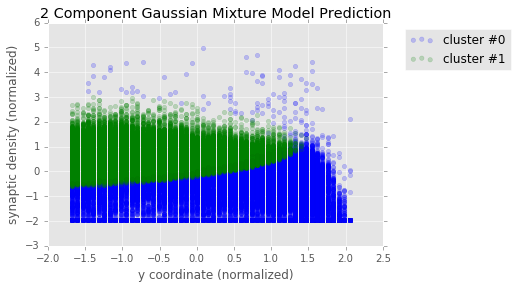

In [7]:
from sklearn import mixture

gmm = mixture.GMM(2)
labels = gmm.fit_predict(data)

print gmm.means_
print "compare with kmeans, k=2, all coordinates"
print kmeans3.cluster_centers_

for i, c in zip(range(2), colors):
    a = np.where(labels == i)
    plt.scatter(data[a, 1], data[a, -1], 
                alpha = .2,
                color = c, 
                label='cluster #' + str(i))

plt.legend(bbox_to_anchor=(1.4, 1.00))
plt.xlabel('y coordinate (normalized)')
plt.ylabel('synaptic density (normalized)')
plt.title('2 Component Gaussian Mixture Model Prediction')
plt.show()

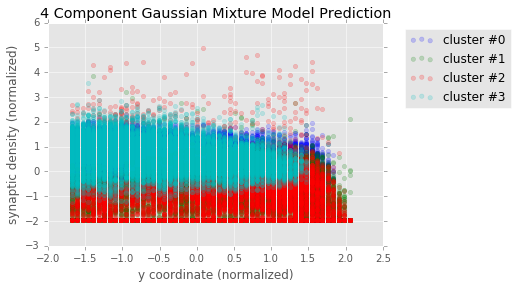

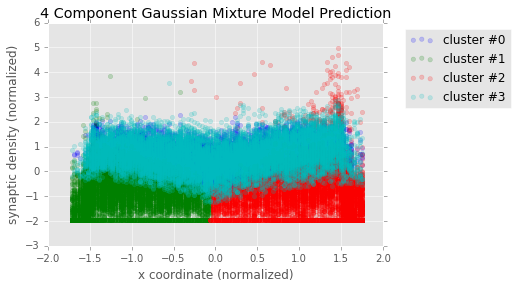

[[ 0.03653512 -0.22358293  0.79335614  0.50232909]
 [-1.09113903  0.40311391  0.04101943 -0.76253853]
 [ 1.03931758  0.41162209  0.03719029 -0.63244876]
 [ 0.04619804 -0.41755019 -0.91884729  0.58901759]]


In [12]:
# now do GMM w/ 4 clusters, since Bock 2011 suggests 4 layers

gmm = mixture.GMM(4)
labels = gmm.fit_predict(data)
for i, c in zip(range(4), colors):
    a = np.where(labels == i)
    plt.scatter(data[a, 1], data[a, -1], 
                alpha = .2,
                color = c, 
                label='cluster #' + str(i))

plt.legend(bbox_to_anchor=(1.4, 1.00))
plt.xlabel('y coordinate (normalized)')
plt.ylabel('synaptic density (normalized)')
plt.title('4 Component Gaussian Mixture Model Prediction')
plt.show()

for i, c in zip(range(4), colors):
    a = np.where(labels == i)
    plt.scatter(data[a, 0], data[a, -1], 
                alpha = .2,
                color = c, 
                label='cluster #' + str(i))

plt.legend(bbox_to_anchor=(1.4, 1.00))
plt.xlabel('x coordinate (normalized)')
plt.ylabel('synaptic density (normalized)')
plt.title('4 Component Gaussian Mixture Model Prediction')
plt.show()

print gmm.means_

### Clustering results for the most part, do not seem to be indicating a particular cut-off between layers, although they indicate some correlation between y coordinates and density.

In [9]:
print np.cov(data[:, 1], data[:, -1])

[[ 1.00001812 -0.32606289]
 [-0.32606289  1.00001812]]


Some negative correlation between density and y coordinate, although not extreme. Let's compare the correlation for each coordinate

In [10]:
for i, coord in enumerate(['cx', 'cy', 'cz']):
    print "correlation between density and " + coord 
    print np.cov(data[:, i], data[:, -1])

correlation between density and cx
[[ 1.00001812  0.08732019]
 [ 0.08732019  1.00001812]]
correlation between density and cy
[[ 1.00001812 -0.32606289]
 [-0.32606289  1.00001812]]
correlation between density and cz
[[ 1.00001812 -0.0349637 ]
 [-0.0349637   1.00001812]]


As expected, absolute value of correlation with density is maximal for y coordinate.